# 0. 데이터 세팅

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import product

import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from mgarch import mgarch
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from pykalman import KalmanFilter
import hurst

In [2]:
VIX = pd.read_csv('VIX.csv',index_col=0,parse_dates=True)[['종가']].astype(float).sort_index(ascending=True)
V2X = pd.read_csv('V2X.csv',index_col=0,parse_dates=True)[['Price']].astype(float).sort_index(ascending=True)
VIX_df = pd.merge(VIX,V2X,left_index=True,right_index=True,how='inner')
VIX_df.columns = ['V1X','V2X']
VIX_df

,V1X,V2X
2012-12-28,22.72,21.35
2013-01-02,14.68,18.36
2013-01-03,14.56,17.54
2013-01-04,13.83,16.07
2013-01-07,13.79,16.82
...,...,...
2024-11-21,16.87,18.95
2024-11-22,15.24,17.97
2024-11-25,14.60,17.21
2024-11-26,14.10,17.73


---

## 1. V1X와 V2X의 시계열을 추세, 계절성 및 잡음으로 분해하라.

In [3]:
# 시계열 분해
result_V1X = seasonal_decompose(VIX_df['V1X'], model='additive', period=12)
result_V2X = seasonal_decompose(VIX_df['V2X'], model='additive', period=12)

In [4]:
def plot_decomposition(result, title):
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(title, fontsize=16)

    axes[0].plot(result.observed, label='Observed')
    axes[0].set_ylabel('Observed')

    axes[1].plot(result.trend, label='Trend')
    axes[1].set_ylabel('Trend')

    axes[2].plot(result.seasonal, label='Seasonal')
    axes[2].set_ylabel('Seasonal')

    axes[3].plot(result.resid, label='Residual')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

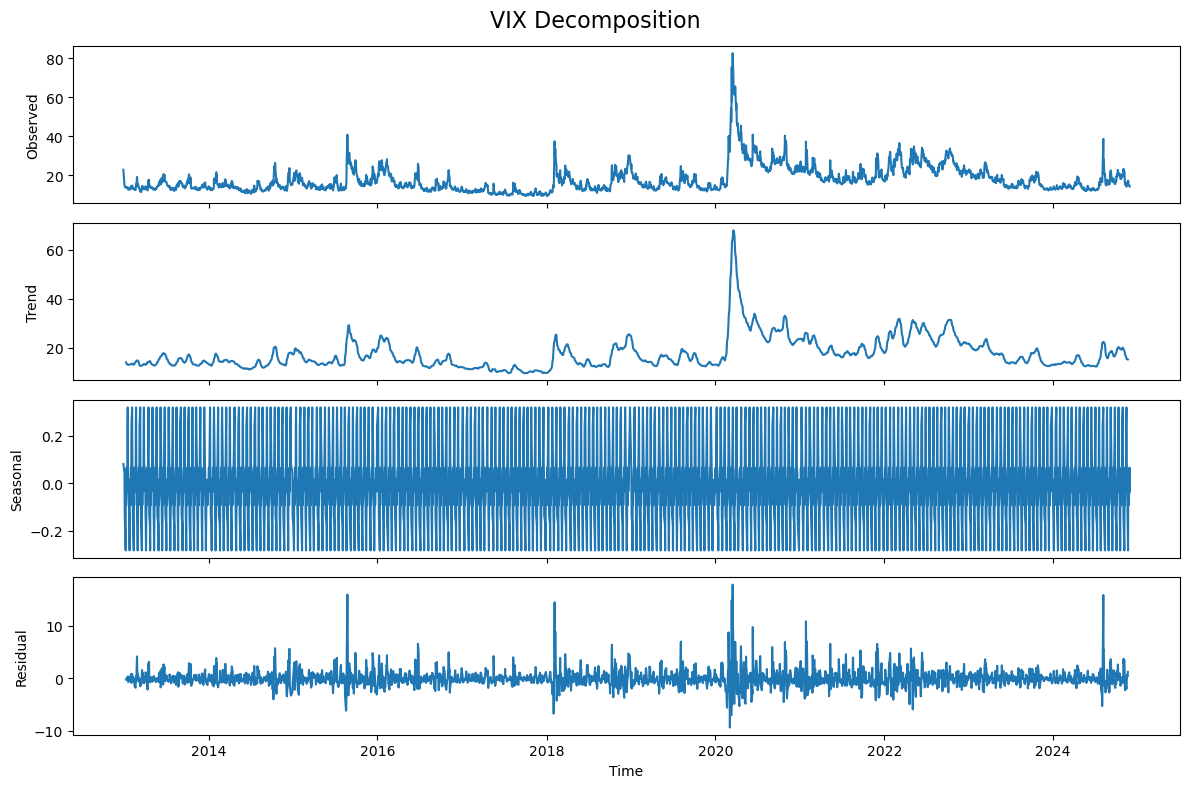

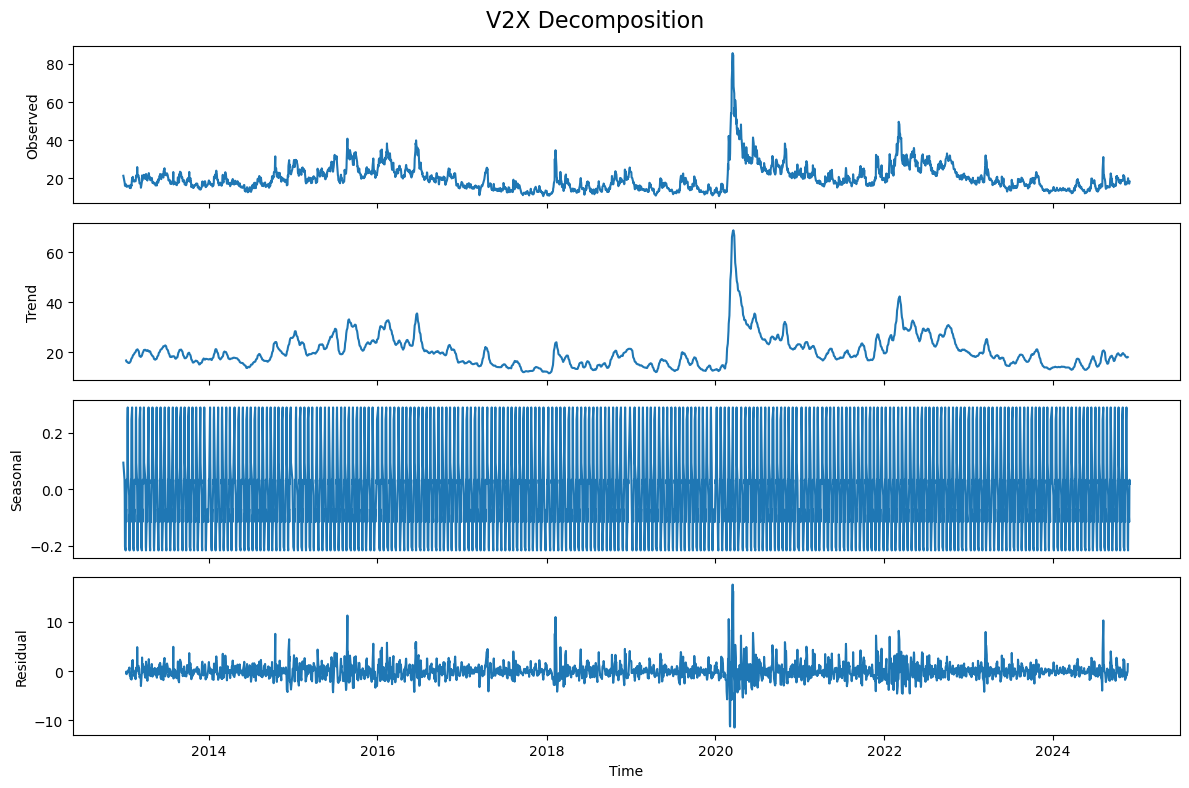

In [5]:
# VIX 시계열 분해 시각화
plot_decomposition(result_V1X, 'VIX Decomposition')
plot_decomposition(result_V2X, 'V2X Decomposition')

---

## 2. VIX와 V2X 각각에 대해 단위근 테스트를 실행하고 정상성을 살펴보라.

In [6]:
# Augmented Dickey-Fuller Test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

adf_test(VIX_df['V1X'])
adf_test(VIX_df['V2X'])

ADF Statistic: -5.504838
p-value: 0.000002
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -6.280245
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Augmented Dickey-Fuller (ADF) 단위근 테스트 결과

가설
- 귀무가설 ( H_0 ): 시계열 데이터는 단위근을 가지고 있으며 비정상성을 띤다.
- 대립가설 ( H_1 ): 시계열 데이터는 단위근이 없으며 정상성을 띤다

---

 결과

 VIX 
- ADF 통계량: -5.504838
- p-value: 0.000002
- 임계값:
  - 1%: -3.433
  - 5%: -2.863
  - 10%: -2.567

결론: 
- ADF 통계량(-5.504838)이 모든 임계값보다 작고 p-value(0.000002)가 0.05보다 훨씬 작다.
- 따라서,  H_0 를 기각한다.  VIX  시계열은 정상성을 가진다.


 V2X 
- ADF 통계량: -6.280245
- p-value: 0.000000
- 임계값:
  - 1%: -3.433
  - 5%: -2.863
  - 10%: -2.567

결론: 
- ADF 통계량(-6.280245)이 모든 임계값보다 작고 p-value(0.000000)가 0.05보다 훨씬 작다.
- 따라서,  H_0 를 기각한다.  V2X  시계열은 정상성을 가진다.

---

최종 결론
 VIX 와  V2X  모두 Augmented Dickey-Fuller 테스트 결과 정상성을 만족한다.

---
## 3. VIX와 V2X 각각에 대해 ARIMA GARCH 모델을 적용하라.

In [7]:
# ARIMA 차수 선택을 알아서 해주는 auto_arima 함수
model_V1X = pm.auto_arima(VIX_df['V1X'], seasonal=False, stepwise=True, 
                        suppress_warnings=True, error_action="ignore", trace=True)
model_V2X = pm.auto_arima(VIX_df['V2X'], seasonal=False, stepwise=True, 
                        suppress_warnings=True, error_action="ignore", trace=True)

model_V1X.fit(VIX_df['V1X'])
model_V2X.fit(VIX_df['V2X'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11887.443, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11976.519, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11893.741, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11897.709, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11974.526, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11896.465, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11897.384, Time=0.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11868.494, Time=1.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11871.703, Time=0.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11869.323, Time=0.98 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11876.113, Time=0.74 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(3,1,2)(0,0,0)[0]             :

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

auto_arima를 사용해  VIX와  V2X 시계열 각각에 대해 최적의 p, d, q값을 자동으로 선택하고 ARIMA 모델을 적합시켰다.

---

결과창:
ARIMA(3,1,2)(0,0,0)[0]             : AIC=11653.045, Time=0.69 sec

최종적으로 VIX 의 최적 모델은 AIC가 가장 작은 ARIMA(3,1,2)로 선택했다.


In [8]:
print(model_V1X.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2986
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -5927.251
Date:                Tue, 03 Dec 2024   AIC                          11866.502
Time:                        23:29:24   BIC                          11902.511
Sample:                             0   HQIC                         11879.458
                               - 2986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8160      0.065    -28.046      0.000      -1.943      -1.689
ar.L2         -1.0181      0.075    -13.556      0.000      -1.165      -0.871
ar.L3         -0.1014      0.018     -5.745      0.0

In [9]:
print(model_V2X.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2986
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -5820.523
Date:                Tue, 03 Dec 2024   AIC                          11653.045
Time:                        23:29:24   BIC                          11689.053
Sample:                             0   HQIC                         11666.000
                               - 2986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6780      0.185      9.072      0.000       1.315       2.041
ar.L2         -0.6490      0.174     -3.730      0.000      -0.990      -0.308
ar.L3         -0.0418      0.009     -4.507      0.0

In [10]:
# ARIMA-GARCH

# 잔차 추출
residuals_V1X = model_V1X.resid()
residuals_V2X = model_V2X.resid()

In [11]:
# arch_model을 활용해 GARCH 모델 최적화 수행
# AIC 기준으로 최적의 p, q 찾기 iteration
def find_best_garch(residuals):
    parameters = product(range(1, 4), range(1, 4))
    best_aic = float('inf')
    best_param = None

    for param in parameters:
        try:
            model = arch_model(residuals, vol='Garch', p=param[0], q=param[1])
            result = model.fit(disp='off')
            if result.aic < best_aic:
                best_aic = result.aic
                best_param = param
        except:
            continue
    return best_param, best_aic

In [12]:
best_param_V1X, best_aic_V1X = find_best_garch(residuals_V1X)
print(f"Best GARCH(p, q) for V1X: {best_param_V1X}, AIC: {best_aic_V1X}")

best_param_V2X, best_aic_V2X = find_best_garch(residuals_V2X)
print(f"Best GARCH(p, q) for V2X: {best_param_V2X}, AIC: {best_aic_V2X}")

Best GARCH(p, q) for V1X: (2, 2), AIC: 10383.188921838753
Best GARCH(p, q) for V2X: (3, 2), AIC: 10595.928697639722


In [13]:
# 최적의 GARCH 모델 학습
garch_V1X = arch_model(residuals_V1X, vol='GARCH', p=best_param_V1X[0], q=best_param_V1X[1])
garch_V2X = arch_model(residuals_V2X, vol='GARCH', p=best_param_V2X[0], q=best_param_V2X[1])

result_garch_V1X = garch_V1X.fit()
result_garch_V2X = garch_V2X.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 15413.075227351828
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1485198.0598332863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 5967.1462104277325
Iteration:      4,   Func. Count:     34,   Neg. LLF: 8395038.976287115
Iteration:      5,   Func. Count:     42,   Neg. LLF: 5273.920344777547
Iteration:      6,   Func. Count:     50,   Neg. LLF: 5381.151831621194
Iteration:      7,   Func. Count:     58,   Neg. LLF: 5190.377040072063
Iteration:      8,   Func. Count:     65,   Neg. LLF: 5189.940730056604
Iteration:      9,   Func. Count:     73,   Neg. LLF: 5938.514090919834
Iteration:     10,   Func. Count:     82,   Neg. LLF: 5185.779687601881
Iteration:     11,   Func. Count:     89,   Neg. LLF: 5185.620611170116
Iteration:     12,   Func. Count:     96,   Neg. LLF: 5185.5969392495845
Iteration:     13,   Func. Count:    103,   Neg. LLF: 5185.594517296191
Iteration:     14,   Func. Count:    110,   Neg. LLF: 5185.5

In [14]:
# 결과 출력
print(result_garch_V1X.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5185.59
Distribution:                  Normal   AIC:                           10383.2
Method:            Maximum Likelihood   BIC:                           10419.2
                                        No. Observations:                 2986
Date:                Tue, Dec 03 2024   Df Residuals:                     2985
Time:                        23:29:24   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0304  2.615e-02     -1.161      0.246 

/Users/byobyo/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/byobyo/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/byobyo/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

In [15]:
print(result_garch_V2X.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5290.96
Distribution:                  Normal   AIC:                           10595.9
Method:            Maximum Likelihood   BIC:                           10637.9
                                        No. Observations:                 2986
Date:                Tue, Dec 03 2024   Df Residuals:                     2985
Time:                        23:29:24   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.0903  2.916e-02     -3.096  1.961e-03 [ -0.1

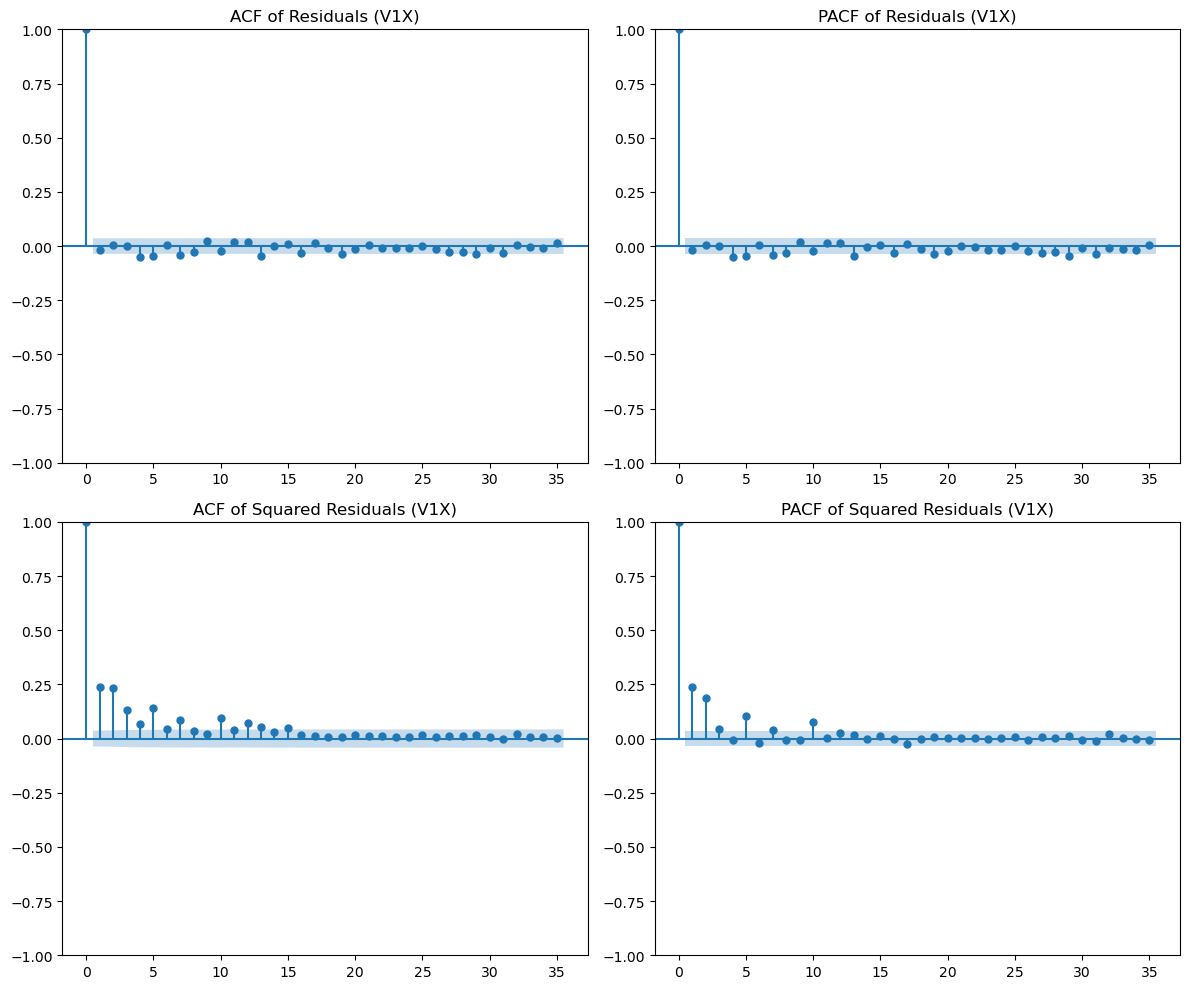

In [16]:
# ARIMA-GARCH 모델의 잔차 분석
# ACF, PACF 그래프를 통해 잔차가 백색잡음인지 확인
## V1X
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuals ACF
plot_acf(result_garch_V1X.resid, ax=axes[0, 0])
axes[0, 0].set_title('ACF of Residuals (V1X)')

# Residuals PACF
plot_pacf(result_garch_V1X.resid, ax=axes[0, 1])
axes[0, 1].set_title('PACF of Residuals (V1X)')

# Squared Residuals ACF
plot_acf(result_garch_V1X.resid**2, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Squared Residuals (V1X)')

# Squared Residuals PACF
plot_pacf(result_garch_V1X.resid**2, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Squared Residuals (V1X)')

plt.tight_layout()
plt.show()

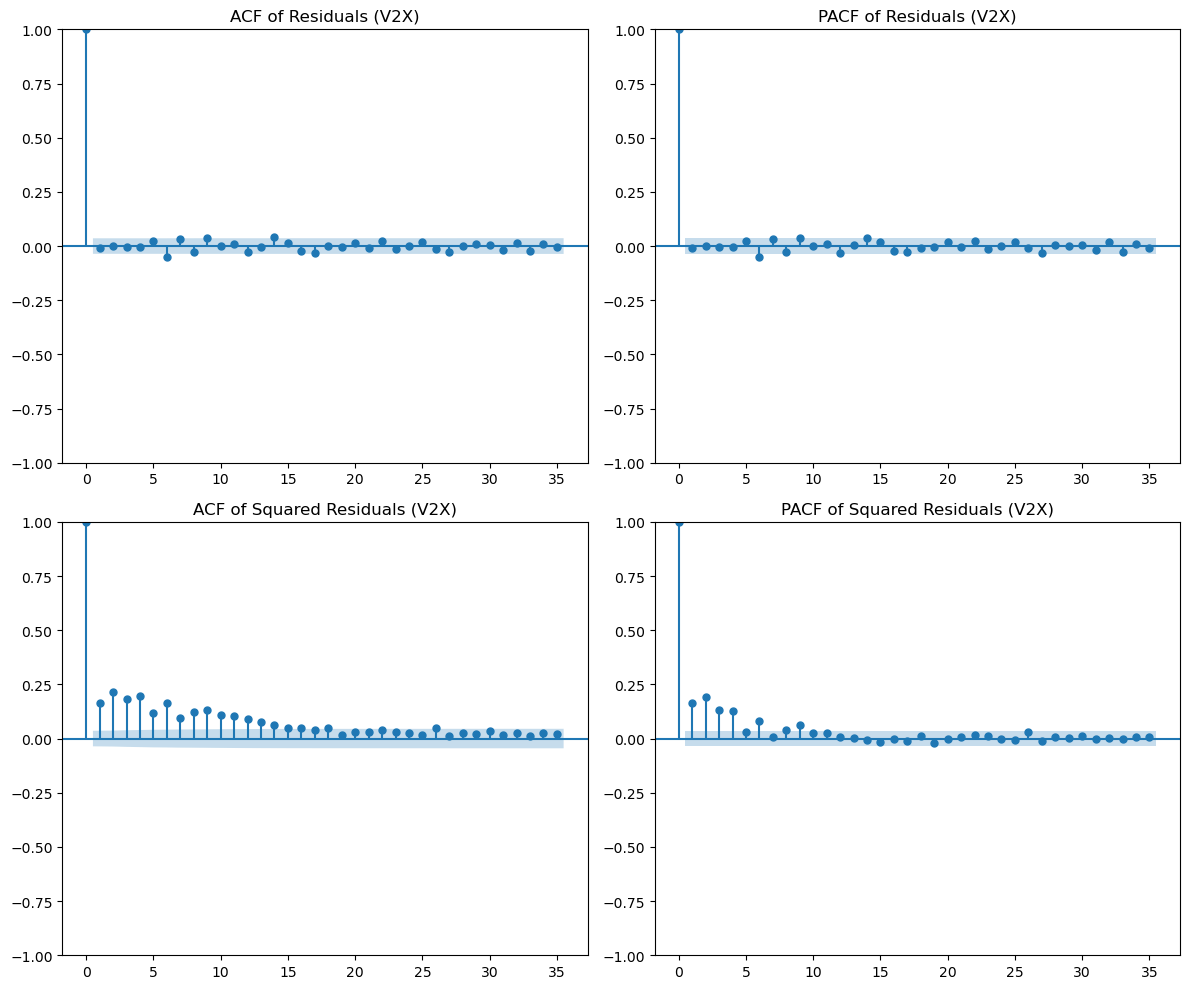

In [17]:
# ARIMA-GARCH 모델의 잔차 분석
# ACF, PACF 그래프를 통해 잔차가 백색잡음인지 확인
## V2X
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuals ACF
plot_acf(result_garch_V2X.resid, ax=axes[0, 0])
axes[0, 0].set_title('ACF of Residuals (V2X)')

# Residuals PACF
plot_pacf(result_garch_V2X.resid, ax=axes[0, 1])
axes[0, 1].set_title('PACF of Residuals (V2X)')

# Squared Residuals ACF
plot_acf(result_garch_V2X.resid**2, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Squared Residuals (V2X)')

# Squared Residuals PACF
plot_pacf(result_garch_V2X.resid**2, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Squared Residuals (V2X)')

plt.tight_layout()
plt.show()

In [18]:
# Ljung-Box 검정
## 변동성이 백색잡음인지 확인
lb_test_V1X = acorr_ljungbox(result_garch_V1X.resid**2, return_df=True)
print('-'*50)
print('VIX')
print(lb_test_V1X)
lb_test_V2X = acorr_ljungbox(result_garch_V2X.resid**2, return_df=True)
print('-'*50)
print('V2X')
print(lb_test_V2X)

--------------------------------------------------
VIX
       lb_stat      lb_pvalue
1   167.509220   2.589409e-38
2   328.676947   4.253121e-72
3   379.256093   6.888628e-82
4   393.241178   8.027778e-84
5   452.765351   1.243817e-95
6   458.157817   8.610453e-96
7   480.623685   1.171594e-99
8   484.351311   1.599854e-99
9   485.888718   6.032690e-99
10  514.123909  4.228007e-104
--------------------------------------------------
V2X
       lb_stat      lb_pvalue
1    79.086635   5.944511e-19
2   217.419589   6.136716e-48
3   316.516106   2.647918e-68
4   432.499509   2.635629e-92
5   474.696070  2.308033e-100
6   555.777660  8.021439e-117
7   582.539011  1.400081e-121
8   626.558598  4.553428e-130
9   679.323965  1.923890e-140
10  713.822590  6.765577e-147


### ARIMA-GARCH 모델 잔차 분석 결과 해석

---

#### 1. 잔차의 ACF (왼쪽 위)
- 잔차의 ACF에서 모든 시차가 신뢰구간 내에 있다.
- 즉 잔차가 자기상관이 없는 white noise에 가깝다.
- 결론: ARIMA 모델이 평균값을 잘 설명했다.


#### 2. 잔차의 PACF (오른쪽 위)
- 잔차의 PACF도 모든 시차에서 신뢰구간 내에 있다.
- 즉 잔차에 추가적인 AR 구조가 없음을 의미한다.
- 결론: ARIMA 모델이 적절히 평균값의 자기상관을 제거했다.


#### 3. 잔차 제곱의 ACF (왼쪽 아래)
- 잔차 제곱의 ACF에서 일부 시차에서 신뢰구간을 약간 벗어난다.
- 즉 변동성 클러스터링이 완전히 제거되지 않았을 가능성이 있다.
- 결론: GARCH(2,2)(V1X), GARCH(3,2)(V2X) 모델이 변동성을 대부분 잘 설명했지만 추가적인 변동성을 더 설명할 여지가 있다.


#### 4. 잔차 제곱의 PACF (오른쪽 아래)
- 잔차 제곱의 PACF도 초기 몇 개의 시차에서 신뢰구간을 약간 벗어난다.
- 즉 잔차 제곱의 자기상관 중 일부가 GARCH(2,2)(V1X), GARCH(3,2)(V2X) 모델로 충분히 제거되지 않았음을 나타낸다.
- 결론: 모델 개선 여지가 존재한다.


#### 5. Ljung-Box 검정
1.	가설 :

	•	 H_0 : 잔차의 제곱값에 자기상관이 없다 (백색잡음).
	
	•	 H_1 : 잔차의 제곱값에 자기상관이 있다 (백색잡음 아님).
2.	결과 해석:

	•	p-value:

	•	 p < 0.05 : 귀무가설( H_0 )을 기각 → 자기상관이 있음 → 모델이 변동성을 충분히 설명하지 못한다.

	•	 p >= 0.05 : 귀무가설( H_0 )을 채택 → 자기상관이 없음 → 모델이 변동성을 잘 설명한다.
3.	결과 값:

	•	 VIX 와  V2X  모두 모든 lag에서 p-value가 매우 작다 ( p < 0.05 ).
	
	•	이는 잔차의 제곱값에 자기상관이 존재함을 나타낸다.
---

### 결론
1. ARIMA 모델 적합성:
   - 잔차의 ACF와 PACF 모두 신뢰구간 내에 있어 ARIMA 모델이 평균값을 잘 설명한다.
   - 추가적인 평균 자기상관은 존재하지 않는다.

2. GARCH 모델 적합성:
   - 잔차 제곱의 ACF와 PACF에서 초기 시차에서 약간의 자기상관이 남아 있다.
   - Ljung-Box 검정결과에서도 자기상관이 존재한다.
   - 변동성 클러스터링을 완전히 제거하지 못했을 가능성이 있으며 GARCH 모델의 구조를 개선할 필요가 있다.

---
## 4. VIX와 V2X에 대해 Multivariate GARCH 모델를 적용해보라.

In [19]:
# 로그 수익률 계산
VIX_df2 = VIX_df.copy()
VIX_df2['V1X_return'] = np.log(VIX_df2['V1X'] / VIX_df2['V1X'].shift(1))
VIX_df2['V2X_return'] = np.log(VIX_df2['V2X'] / VIX_df2['V2X'].shift(1))

# 로그 수익률 데이터 추출
VIX_df2 = VIX_df2[['V1X_return', 'V2X_return']].dropna()

In [20]:
dcc_model = mgarch(dist='norm')
result = dcc_model.fit(VIX_df2.values)
print("DCC-GARCH Model Results:")
print(result)

DCC-GARCH Model Results:
{'mu': matrix([[-1.59822712e-04, -5.16417688e-05]]), 'alpha': 0.0015756039204451048, 'beta': 0.619644413879329}


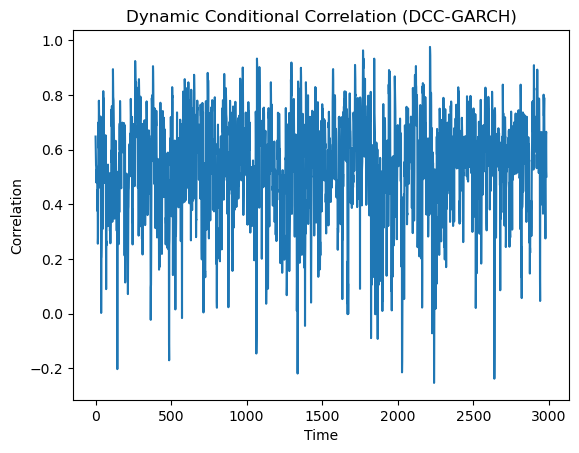

In [21]:
# 동적 상관관계 계산 및 시각화
R_t = []
Q_bar = np.cov(dcc_model.rt.T)  # 무조건부 공분산 행렬
Q_t = Q_bar  # 초기 Q_t 설정

for t in range(dcc_model.T):
    diag_D = np.diag(dcc_model.D_t[t])  # D_t의 대각 행렬
    D_inv = np.linalg.inv(diag_D)  # D_t의 역행렬
    et = D_inv @ dcc_model.rt[t].T  # 표준화된 잔차
    # Q_t 업데이트 (조건부 공분산 행렬)
    Q_t = (1 - dcc_model.a - dcc_model.b) * Q_bar + dcc_model.a * (et @ et.T) + dcc_model.b * Q_t
    # Q_t를 상관행렬 R_t로 변환
    diag_Q = np.sqrt(np.diag(Q_t))
    R = Q_t / np.outer(diag_Q, diag_Q)  # 정규화하여 상관행렬 생성
    R_t.append(R)

# 동적 상관계수 추출 및 시각화
dynamic_corr = [R[0, 1] for R in R_t]  # 첫 번째와 두 번째 변수 간 상관계수
plt.plot(dynamic_corr)
plt.title("Dynamic Conditional Correlation (DCC-GARCH)")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.show()

DCC-GARCH 모델을 사용하여 VIX와 V2X의 동적 조건부 상관관계를 분석한 결과 두 시장의 변동성 간의 관계가 시간에 따라 복잡하게 변화한다.

---
## 5. V1X와 V2X를 이용해 VAR 모델을 만들고, Granger causality 테스트를 실행하고,Impulse response 그래프와 분산 분해(Varinace Decomposion)을 계산하고 그래프로 보여라.

In [22]:
# VAR 모델 적합
model_var = VAR(VIX_df[['V1X', 'V2X']]) # V1X, V2X 변수가 정상성을 만족했기 때문에 바로 VAR 모델 적합
results_var = model_var.fit(maxlags=15, ic='aic') # 최적의 lag 차수는 AIC 기준으로 선택

# 결과 출력
print(results_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Dec, 2024
Time:                     23:29:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.67034
Nobs:                     2971.00    HQIC:                   1.59023
Log likelihood:          -10664.7    FPE:                    4.68891
AIC:                      1.54520    Det(Omega_mle):         4.59257
--------------------------------------------------------------------
Results for equation V1X
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.563998         0.107891            5.227           0.000
L1.V1X          0.798282         0.023974           33.298           0.000
L1.V2X          0.045727         0.025974            1.760           0.078
L2.V1X     

/Users/byobyo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
# Granger causality 테스트
# V1X_return이 V2X_return에 미치는 영향
granger_v1_to_v2 = results_var.test_causality('V1X', 'V2X', kind='f')
print(granger_v1_to_v2.summary())

# V2X_return이 V1X_return에 미치는 영향
granger_v2_to_v1 = results_var.test_causality('V2X', 'V1X', kind='f')
print(granger_v2_to_v1.summary())

Granger causality F-test. H_0: V2X does not Granger-cause V1X. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         2.616          1.668   0.001 (15, 5880)
------------------------------------------------
Granger causality F-test. H_0: V1X does not Granger-cause V2X. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         24.91          1.668   0.000 (15, 5880)
------------------------------------------------


### Granger Causality 테스트 결과

---

#### 1. V2X → V1X
- 귀무가설 (H_0): "V2X는 V1X를 Granger-cause 하지 않는다."
- Test statistic: 2.616
- Critical value: 1.668
- p-value: 0.001
- 결론: 
  - p-value가 5% 유의수준보다 작으므로 귀무가설을 기각한다.
  - V2X는 V1X를 Granger-cause한다.



#### 2. V1X → V2X
- 귀무가설 (H_0): "V1X는 V2X를 Granger-cause 하지 않는다."
- Test statistic: 24.91
- Critical value: 1.668
- p-value: 0.000
- 결론: 
  - p-value가 5% 유의수준보다 작으므로 귀무가설을 기각한다.
  - V1X는 V2X를 Granger-cause한다.

---

#### 3. 결론
- 양방향 Granger causality 관계가 존재한다:
    - V2X가 V1X에 Granger causality를 미치며, 반대로 V1X도 V2X에 Granger causality를 미친다.
    - 즉 V2X(유럽 변동성 지수)가 과거 정보를 통해 V1X(미국 변동성 지수)의 변동성을 예측하는 데 기여할 수 있음.
    - 반대로 V1X(미국 변동성 지수)가 과거 정보를 통해 V2X(유럽 변동성 지수)의 변동성을 예측하는 데 기여할 수 있음.
- Test statistic에 따라 V1X → V2X의 영향 강도가 더 강한 것으로 보인다.
- 공적분 검정을 통해 두 지수 간의 장기적인 균형 관계를 추가적으로 검토해야하며, VAR 대신 VECM을 고려할 필요가 있다.

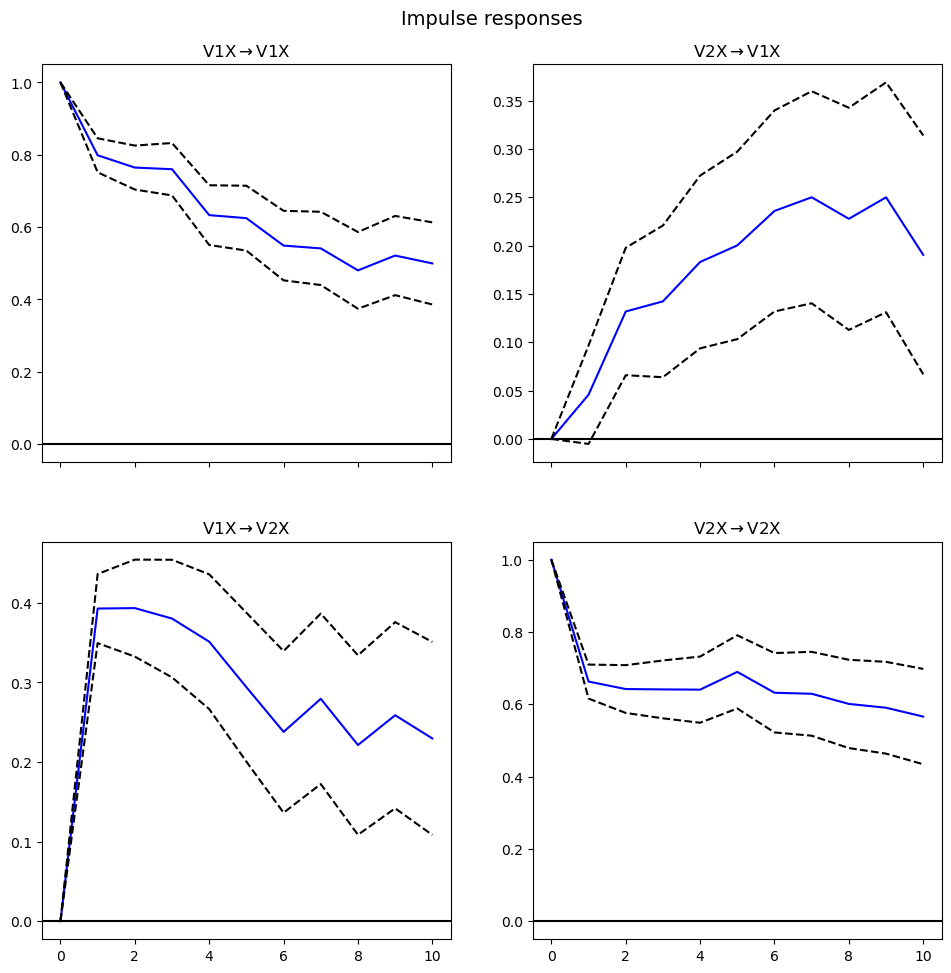

In [24]:
# Impulse response 분석
irf = results_var.irf(10)   # 10개의 기간에 대한 impulse response
irf.plot(orth=False)    # orthogonalized 하지 않은 충격반응을 보여주는 그래프
plt.show()

### Impulse Response Function 해석

#### 1. V1X → V1X (좌상단)
- 설명:
  - V1X가 자기 자신에 미치는 충격.
  - 초기에는 큰 영향을 미치지만 시간이 지남에 따라 점진적으로 감소하며 0으로 수렴한다.
- 해석:
  - V1X의 충격은 단기적으로 강하게 작용하지만 장기적으로 사라지는 특성을 보인다.


#### 2. V2X → V1X (우상단)
- 설명:
  - V2X가 V1X에 미치는 충격.
  - 초기에는 영향이 작지만 시간이 지나면서 증가하다가 점진적으로 감소한다.
- 해석:
  - 유럽 변동성 지수(V2X)의 변화가 미국 변동성 지수(V1X)에 시차를 두고 유의미한 영향을 미친다.


#### 3. V1X → V2X (좌하단)
- 설명:
  - V1X가 V2X에 미치는 충격.
  - 초기에는 큰 영향을 미치며 시간이 지남에 따라 점진적으로 감소한다.
- 해석:
  - 미국 변동성 지수(V1X)는 유럽 변동성 지수(V2X)에 단기적으로 강한 영향을 미치며 시간이 지나면서 그 영향이 감소한다.


#### 4. V2X → V2X (우하단)
- 설명:
  - V2X가 자기 자신에 미치는 충격.
  - 초기에는 큰 영향을 미치지만 시간이 지남에 따라 점진적으로 감소하며 0으로 수렴한다.
- 해석:
  - V2X의 충격은 자기 자신에게 단기적으로 강하게 작용하지만 장기적으로는 사라지는 특성을 보인다.

---

### 결론
1. 자기 자신에 대한 충격:
   - V1X와 V2X 모두 자기 자신에 대한 충격에 대해 초기 반응은 크지만 시간이 지나면서 감소한다.
   - 즉 금융 데이터의 일반적인 특성(충격이 단기적으로 강하고, 장기적으로 소멸)을 반영한다.

2. 상호 변수 간의 충격:
   - V1X가 V2X에 미치는 영향(V1X → V2X)이 V2X가 V1X에 미치는 영향(V2X → V1X)보다 초기 반응이 강하다.
   - 즉 미국 변동성 지수(V1X)가 유럽 변동성 지수(V2X)에 더 빠르고 강하게 영향을 미치는 구조를 시사한다.
   - V2X 충격이 V1X에 미치는 영향은 일정한 시차를 두고 발생한다.

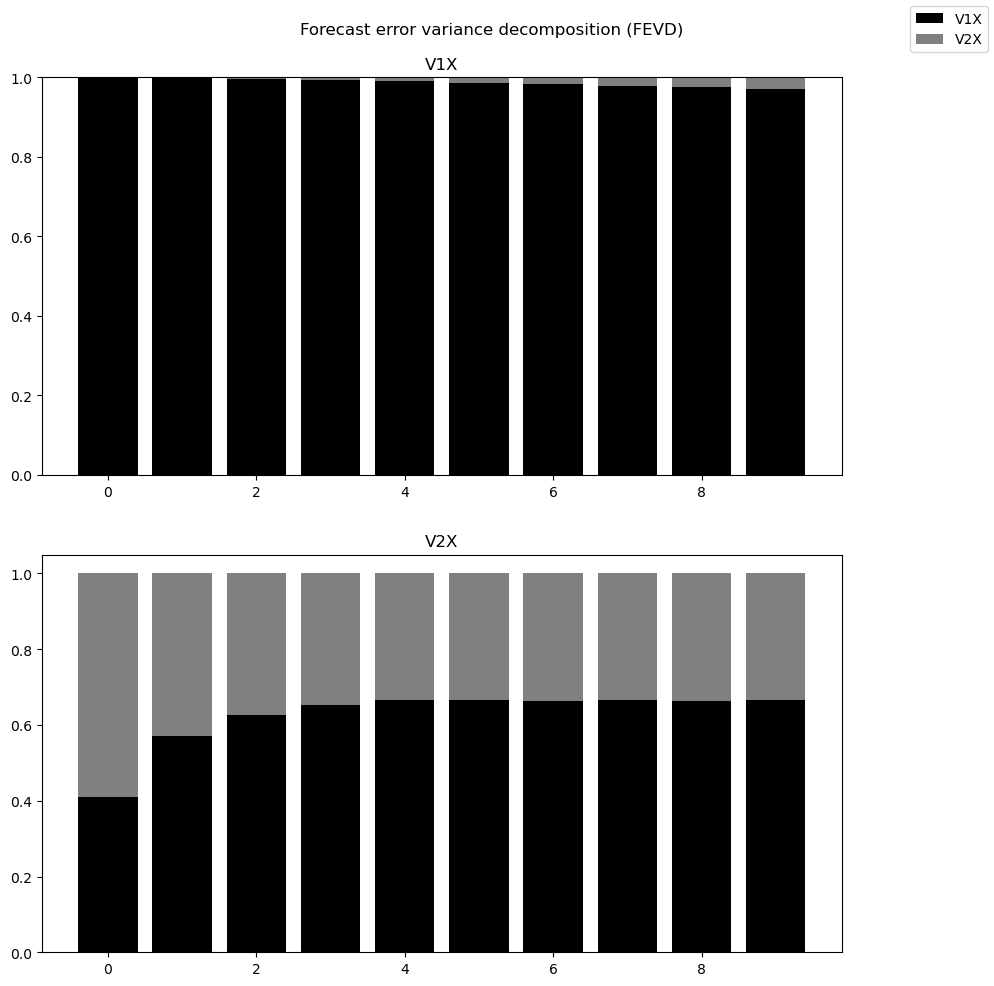

In [25]:
# Variance Decomposition 분석
vd = results_var.fevd(10)   # 10개의 기간에 대한 Variance Decomposition
vd.plot()
plt.show()

### Variance Decomposition분석
---

#### 1. V1X의 Variance Decomposition (상단)
- 설명:
  - V1X의 예측 오차 분산이 대부분 V1X 자체에 의해 설명된다.
  - 다른 변수인 V2X는 V1X의 예측 오차 분산에 거의 기여하지 않는다.
- 해석:
  - V1X는 자기 자신에 의한 설명력이 매우 높으며 V2X의 충격은 V1X의 예측 오차 분산에 유의미한 영향을 미치지 않는다.
  - 즉 V1X가 독립적인 성격을 가질 가능성을 시사한다.


#### 2. V2X의 Variance Decomposition (하단)
- 설명:
  - V2X의 예측 오차 분산은 초기에는 V1X와 V2X 모두에 의해 설명된다.
  - 시간이 지남에 따라 V1X의 기여도는 점차 감소하고 V2X 자체의 기여도가 증가한다.
- 해석:
  - 초기에는 V1X가 V2X의 예측 오차 분산에 영향을 미치지만 시간이 지남에 따라 V2X가 점점 더 큰 설명력을 가지게 된다.
  - 즉 단기적으로는 V1X의 영향이 중요하지만 장기적으로 V2X의 자체적인 영향이라는 것을 시사한다.

---

#### 결론
1. V1X는 독립적인 변수:
   - V1X의 예측 오차 분산은 거의 전적으로 자기 자신에 의해 설명된다.
   - 이는 V1X가 외부 충격보다 내부 요인에 의해 좌우됨을 시사한다.

2. V2X는 V1X의 영향을 받음:
   - V2X의 예측 오차 분산은 초기에는 V1X에 의해 상당 부분 설명되며 이는 V1X가 V2X에 단기적으로 영향을 미친다.
   - 그러나 장기적으로는 V2X 자체가 지배적인 설명력을 가진다.


---
## 6. V1X와 V2X를 이용해 공적분관계를 확인하고, VECM 모델을 구축하라.

In [26]:
# Johansen 공적분 검정
result_coint = coint_johansen(VIX_df[['V1X', 'V2X']], det_order=0, k_ar_diff=1)

# Trace Statistic과 임계값 출력
print("Trace Statistic:", result_coint.lr1)
print("Critical Values (Trace):", result_coint.cvt)

# Maximum Eigenvalue Statistic과 임계값 출력
print("Maximum Eigenvalue Statistic:", result_coint.lr2)
print("Critical Values (Max-Eigen):", result_coint.cvm)

Trace Statistic: [110.98581484  36.36566577]
Critical Values (Trace): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Maximum Eigenvalue Statistic: [74.62014907 36.36566577]
Critical Values (Max-Eigen): [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


### 요한센 공적분 검정 결과 해석

---

#### 1. Trace Statistic 해석
1. 검정 통계량 (Trace Statistic): [110.98581484, 36.36566577]
   - 각 값은 공적분 벡터의 수 (r)에 따라 계산된 통계량을 의미한다.
   - 첫 번째 값: r = 0 (공적분 벡터가 없다는 귀무가설에 대한 검정).
   - 두 번째 값: r = 1 (최대 1개의 공적분 벡터가 있다는 귀무가설에 대한 검정).

2. 임계값 (Critical Values):
   - r = 0: [13.4294, 15.4943, 19.9349] (10%, 5%, 1% 유의수준).
   - r = 1: [2.7055, 3.8415, 6.6349] (10%, 5%, 1% 유의수준).

#### 결과 해석:
1. 첫 번째 공적분 벡터 (r = 0):
   - 검정 통계량 (110.99) > 임계값 (19.93 at 1% 유의수준).
   - 귀무가설(r = 0, 공적분 벡터가 없음)을 기각 → 최소 1개 이상의 공적분 관계가 존재한다.

2. 두 번째 공적분 벡터 (r = 1):
   - 검정 통계량 (36.37) > 임계값 (6.63 at 1% 유의수준).
   - 귀무가설(r \leq 1, 최대 1개의 공적분 벡터가 존재)을 기각 → 최소 2개 이상의 공적분 관계가 존재 가능하다.


#### 2. Maximum Eigenvalue Statistic 해석
1. 검정 통계량 (Max-Eigen Statistic): [74.62014907, 36.36566577]
   - 각 값은 공적분 벡터의 수 (r)에 따라 계산된 통계량을 의미한다.
   - 첫 번째 값: r = 0 (공적분 벡터가 없다는 귀무가설에 대한 검정).
   - 두 번째 값: r = 1 (최대 1개의 공적분 벡터가 있다는 귀무가설에 대한 검정).

2. 임계값 (Critical Values):
   - r = 0: [12.2971, 14.2639, 18.52] (10%, 5%, 1% 유의수준).
   - r = 1: [2.7055, 3.8415, 6.6349] (10%, 5%, 1% 유의수준).

---

#### 결과 해석:
1. 첫 번째 공적분 벡터 (r = 0):
   - 검정 통계량 (74.62) > 임계값 (18.52 at 1% 유의수준).
   - 귀무가설(r = 0, 공적분 벡터가 없음)을 기각 → 최소 1개 이상의 공적분 관계가 존재한다.

2. 두 번째 공적분 벡터 (r = 1):
   - 검정 통계량 (36.37) > 임계값 (6.63 at 1% 유의수준).
   - 귀무가설(r = 1, 최대 1개의 공적분 벡터가 존재)을 기각 → 최소 2개 이상의 공적분 관계가 존재 가능하다.

---

#### 3. 결론
- Trace Statistic과 Maximum Eigenvalue Statistic 모두 r = 1에 대해 귀무가설을 기각하므로, 최소 2개의 공적분 관계가 존재한다고 결론내릴 수 있다.

In [27]:
# VECM 모델 적합
model_vecm = VECM(VIX_df[['V1X', 'V2X']], k_ar_diff=1, coint_rank=2)
results_vecm = model_vecm.fit()

# 결과 출력
print(results_vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation V1X
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.V1X        -0.1497      0.022     -6.726      0.000      -0.193      -0.106
L1.V2X        -0.0093      0.023     -0.404      0.686      -0.054       0.036
Det. terms outside the coint. relation & lagged endog. parameters for equation V2X
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.V1X         0.2897      0.021     13.950      0.000       0.249       0.330
L1.V2X        -0.2227      0.021    -10.396      0.000      -0.265      -0.181
                Loading coefficients (alpha) for equation V1X                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

/Users/byobyo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### VECM 결과 해석

---

#### 1. 각 방정식의 계수

#### 1.1 V1X 방정식

$$
  \Delta V1X_t = \alpha_1 \cdot ec1 + \alpha_2 \cdot ec2 + \beta_1 \cdot \Delta V1X_{t-1} + \beta_2 \cdot \Delta V2X_{t-1} + \epsilon_t
$$

- L1.V1X:
  - 계수: -0.1497, p-value < 0.01 → 유의미.
  - 이전 시점 V1X의 변화가 현재 V1X에 음의 영향을 미침.
- L1.V2X:
  - 계수: -0.0093, p-value = 0.686 → 유의미하지 않음.
  - V2X의 변화는 현재 V1X에 거의 영향을 미치지 않음.

#### 1.2 V2X 방정식
$$
\Delta V2X_t = \alpha_3 \cdot ec1 + \alpha_4 \cdot ec2 + \beta_3 \cdot \Delta V1X_{t-1} + \beta_4 \cdot \Delta V2X_{t-1} + \epsilon_t
$$

- L1.V1X:
  - 계수: 0.2897, p-value < 0.01 → 유의미.
  - 이전 시점 V1X의 변화가 현재 V2X에 양의 영향을 미친다.
- L1.V2X:
  - 계수: -0.2227, p-value < 0.01 → 유의미.
  - 이전 시점 V2X의 변화가 현재 V2X에 음의 영향을 미친다.

---

#### 2. 오차 수정 항 (Error Correction Term, ec)

#### 2.1 V1X의 오차 수정 계수 (alpha_1, alpha_2)
- ec1: -0.0334, p-value < 0.01 → 유의미.
  - V1X는 장기 균형에서 벗어날 경우 균형으로 복귀하려는 음의 조정 메커니즘이 작동한다.
- ec2: 0.0269, p-value < 0.01 → 유의미.
  - V1X는 장기 균형에서 벗어날 경우 추가적인 양의 조정 메커니즘이 작동한다.

#### 2.2 V2X의 오차 수정 계수 (alpha_3, alpha_4)
- ec1: 0.0331, p-value < 0.01 → 유의미.
  - V2X는 장기 균형에서 벗어날 경우 균형으로 복귀하려는 양의 조정 메커니즘이 작동한다.
- ec2: -0.0318, p-value < 0.01 → 유의미.
  - V2X는 장기 균형에서 벗어날 경우 음의 조정 메커니즘이 작동한다.

---

#### 3. 공적분 벡터 (Cointegration Relations)

#### 3.1 첫 번째 공적분 벡터 (ec1)
- beta.1: 1.0000
- beta.2: $$ 1.199 \times 10^{-17} $$ (0에 가까움)
- 해석:
  - ec1은 V1X의 장기적인 균형 관계.

#### 3.2 두 번째 공적분 벡터 (ec2)
- beta.1: $$ 4.085 \times 10^{-18}$$ (0에 가까움)
- beta.2: 1.0000
- 해석:
  - ec2는 V2X의 장기적인 균형 관계.

---

#### 4. 결론
1. 장기 관계:
   - V1X와 V2X는 두 개의 공적분 관계를 통해 장기적인 균형을 유지한다.
   - 균형에서 벗어날 경우 오차 수정 항(ec)을 통해 복귀 메커니즘이 작동한다.

2. 단기 관계:
   - V1X는 V2X의 변화에 민감하지 않지만, V2X는 V1X의 변화에 민감하게 반응한다.
   - 즉 미국 변동성 지수(V1X)가 유럽 변동성 지수(V2X)에 강한 단기적 영향을 미친다는 것을 의미한다.(L1.V1X = 0.2897)


---

## 7. 페어트레이딩 (트레이딩 경계: 평균 +/- some 표준편차)

(1) 단순 스프레드를 이용한 페어 트레이딩

(2) 공적분관계를 이용한 페어트레이딩

(3) 칼만 필터를 이용한 페어트레이딩

In [28]:
# 트레이딩은 선물 데이터를 사용
VIX_f = pd.read_csv('VIX_futures.csv',index_col=0,parse_dates=True)[['종가']].astype(float).sort_index(ascending=True)
V2X_f = pd.read_csv('V2X_futures.csv',index_col=0,parse_dates=True)[['Price']].astype(float).sort_index(ascending=True)
EUR_USD = pd.read_csv('EUR_USD.csv',index_col=0,parse_dates=True)[['Price']].astype(float).sort_index(ascending=True)

VIX_f_df = pd.merge(VIX_f,V2X_f,left_index=True,right_index=True,how='inner')
VIX_f_df = pd.merge(VIX_f_df,EUR_USD,left_index=True,right_index=True,how='inner')
VIX_f_df.columns = ['V1X_F','V2X_F','EUR_USD']

VIX_f_df['V2X_F'] = (VIX_f_df['V2X_F'] * VIX_f_df['EUR_USD']).round(2) # 환율 적용
VIX_f_df = VIX_f_df.drop(columns='EUR_USD')

Total_VIX_df = pd.merge(VIX_df,VIX_f_df,left_index=True,right_index=True,how='inner')
Total_VIX_df

,V1X,V2X,V1X_F,V2X_F
2013-06-24,20.11,25.30,20.15,32.47
2013-06-25,18.47,24.14,19.45,31.47
2013-06-26,17.21,22.55,18.85,30.06
2013-06-27,16.86,21.69,18.20,29.27
2013-06-28,16.86,21.82,18.05,29.40
...,...,...,...,...
2024-11-21,16.87,18.95,16.77,18.96
2024-11-22,15.24,17.97,16.07,18.39
2024-11-25,14.60,17.21,15.45,17.47
2024-11-26,14.10,17.73,15.25,17.62


### 7.1 단순 스프레드를 이용한 페어 트레이딩

In [ ]:
# (1) 단순 스프레드 기반 페어 트레이딩 전략
def simple_spread_strategy(df, lookback, k):

    import warnings
    warnings.filterwarnings("ignore")
    
    df = df.copy()
    df['spread'] = df['V1X'] - df['V2X']
    df['mu'] = df['spread'].rolling(window=lookback).mean()
    df['sigma'] = df['spread'].rolling(window=lookback).std()

    # thresholds
    df['low'] = df['mu'] - k * df['sigma']
    df['high'] = df['mu'] + k * df['sigma']

    # positions
    df['position'] = 0.0  # Initialize position
    df.loc[df['spread'] < df['low'], 'position'] = (df['low'] - df['spread']) / df['sigma'] # z-score화
    df.loc[df['spread'] > df['high'], 'position'] = -(df['spread'] - df['high']) / df['sigma']  # z-score화
    df.loc[(df['spread'] > df['mu']) & (df['spread'].shift(1) < df['mu']), 'position'] = 0.0  # 스프레드가 평균을 상향 돌파할 때 청산
    df.loc[(df['spread'] < df['mu']) & (df['spread'].shift(1) > df['mu']), 'position'] = 0.0  # 스프레드가 평균을 하향 돌파할 때 청산
    
    return df

def smooth_positions(df, min_change=0.05, max_change=0.2, max_position=0.5):

    df = df.copy()
    df['smoothed_position'] = df['position']
    for i in range(1, len(df)):
        prev_position = df.loc[df.index[i-1], 'smoothed_position']
        raw_position = df.loc[df.index[i], 'position']
        
        # Smoothing
        # 변화량이 너무 작으면 이전 포지션 유지
        # 변화량이 너무 크면 max_change로 제한
        if abs(raw_position - prev_position) < min_change:
            df.loc[df.index[i], 'smoothed_position'] = prev_position
        else:
            change = np.clip(raw_position - prev_position, -max_change, max_change)
            new_position = prev_position + change
            df.loc[df.index[i], 'smoothed_position'] = np.clip(new_position, -max_position, max_position)
    df['position'] = df['smoothed_position']
    return df

In [75]:
signals_simple = simple_spread_strategy(Total_VIX_df, lookback=40, k=1)
signals_smoothed = smooth_positions(signals_simple)

In [76]:
def plot_spread(result, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(result.index, result['spread'], label='Spread', color='blue')
    ax.plot(result.index, result['low'], linestyle='--', label='Lower', color='red')
    ax.plot(result.index, result['high'], linestyle='--', label='Upper', color='green')
    ax.set_xlabel('Date')
    ax.set_ylabel('Spread')
    ax.set_title(title)
    ax.legend()
    plt.show()

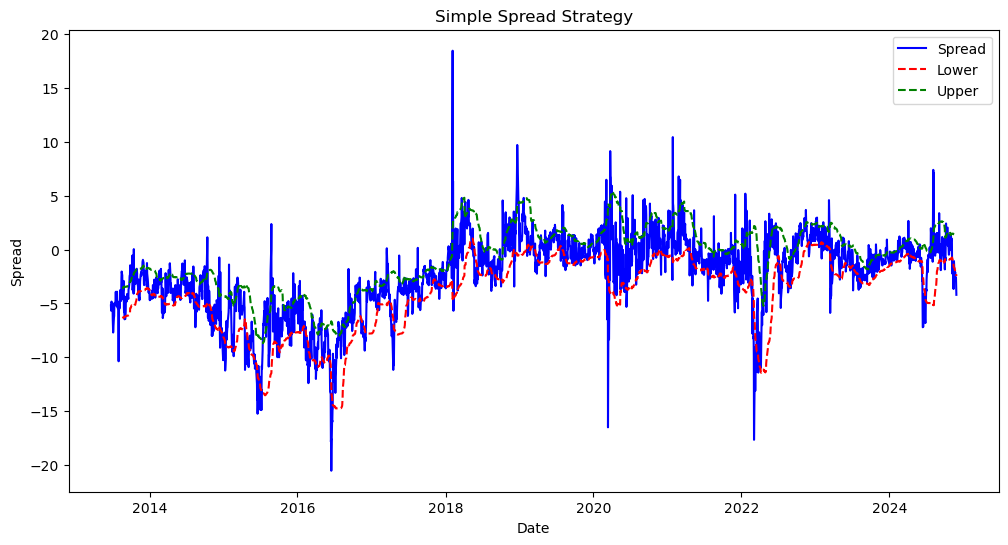

In [77]:
plot_spread(signals_simple, 'Simple Spread Strategy')

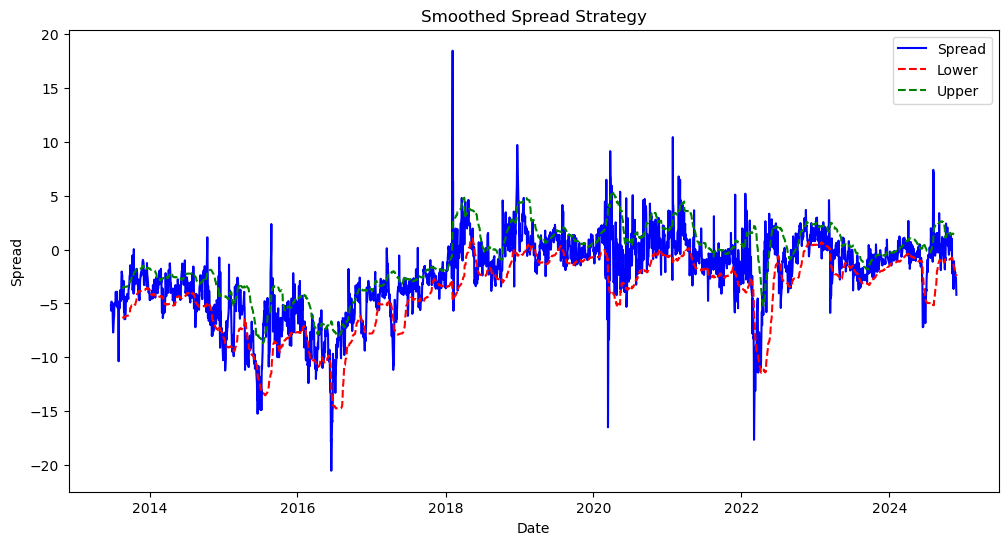

In [78]:
plot_spread(signals_smoothed, 'Smoothed Spread Strategy')

### 7.2 Cointegration

In [97]:
# (2) Cointegration 기반 페어 트레이딩 전략
def coint_based_strategy(df, lookback, k):

    from statsmodels.tsa.stattools import coint

    df = df.copy()
    # Initialize columns
    df['spread'] = np.nan
    df['mu'] = np.nan
    df['high'] = np.nan
    df['low'] = np.nan
    
    for i in range(lookback, len(df)):
        window = df.iloc[i - lookback:i]
        
        score, p_value, _ = coint(window['V1X'], window['V2X'])
        if p_value < 0.05: # Cointegration이 성립해야만 전략 수행
            hedge_ratio = np.polyfit(window['V2X'], window['V1X'], 1)[0] # V1X = hedge_ratio * V2X + beta_0
            spread = window['V1X'] - hedge_ratio * window['V2X']

            mean = spread.mean()
            sigma = spread.std()
            high = mean + k * sigma
            low = mean - k * sigma


            df.loc[df.index[i], 'spread'] = spread.iloc[-1] # rolling한 후 현재 시점의 스프레드 값
            df.loc[df.index[i], 'sigma'] = sigma
            df.loc[df.index[i], 'mu'] = mean
            df.loc[df.index[i], 'high'] = high
            df.loc[df.index[i], 'low'] = low      
        else:
            # Cointegration이 성립하지 않으면 이전 값을 그대로 사용
            df.loc[df.index[i], 'spread'] = df.loc[df.index[i - 1], 'spread']
            df.loc[df.index[i], 'sigma'] = df.loc[df.index[i - 1], 'sigma']
            df.loc[df.index[i], 'mu'] = df.loc[df.index[i - 1], 'mu']
            df.loc[df.index[i], 'high'] = df.loc[df.index[i - 1], 'high']
            df.loc[df.index[i], 'low'] = df.loc[df.index[i - 1], 'low']

    # positions
    df['position'] = 0.0  # Initialize position
    df.loc[df['spread'] < df['low'], 'position'] = (df['low'] - df['spread']) / df['sigma'] # z-score화
    df.loc[df['spread'] > df['high'], 'position'] = -(df['spread'] - df['high']) / df['sigma']  # z-score화
    df.loc[(df['spread'] > df['mu']) & (df['spread'].shift(1) < df['mu']), 'position'] = 0.0  # 스프레드가 평균을 상향 돌파할 때 청산
    df.loc[(df['spread'] < df['mu']) & (df['spread'].shift(1) > df['mu']), 'position'] = 0.0  # 스프레드가 평균을 하향 돌파할 때 청산
    return df

In [98]:
signals_coint = coint_based_strategy(Total_VIX_df, lookback=40, k=1)

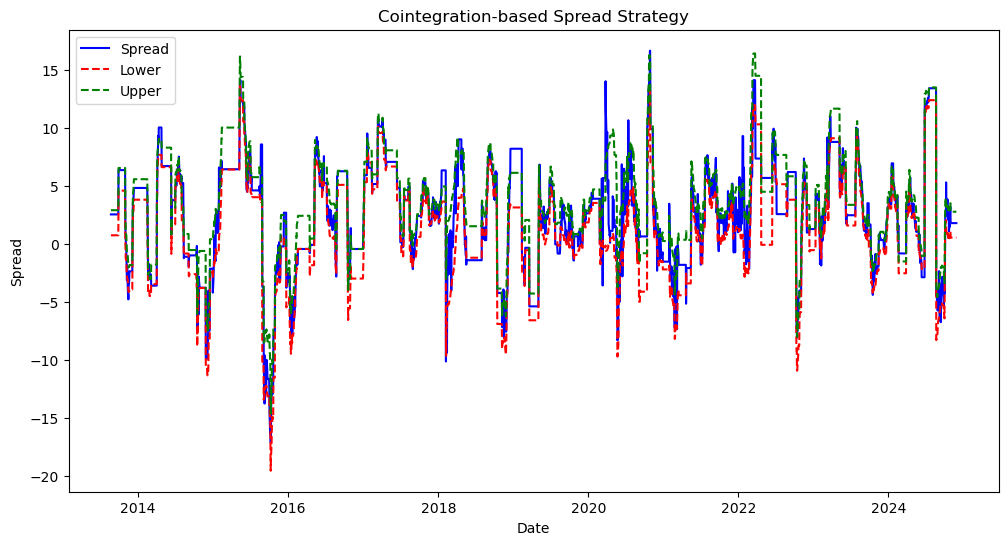

In [99]:
plot_spread(signals_coint, 'Cointegration-based Spread Strategy')

### 7.3 Kalman filter을 이용한 pair trading

In [68]:
# (3) Kalman Filter 기반 페어 트레이딩 전략
def kalman_based_strategy(df, lookback, k):

    df = df.copy()

    # 관측값 y_t가 상태 변수 beta_0, beta_1와 어떤 관계가 있는지를 정의하는 관측 행렬
    obs_mat = sm.add_constant(df['V2X'].values, prepend=False)[:, np.newaxis] # y = beta_0 + beta_1 * x + epsilon ## 칼만필터 입력형식에 맞추기 위해 2차원 배열로 확장
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2) # 상태 전이 잡음의 분산은 delta / (1 - delta)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # 관측(y)은 1-dimensional, (beta_0, beta_2) 는 2-dimensional
                    initial_state_mean=np.zeros(2), # 초기 상태 평균은 [0, 0]
                    initial_state_covariance=np.ones((2, 2)),  # 초기 상태 공분산은 단위 행렬
                    transition_matrices=np.eye(2), # 상태 전이 행렬은 단위 행렬로 설정
                    observation_matrices=obs_mat, # 관측(y) 행렬은 관측값과 상태 변수의 관계를 나타내는 행렬
                    observation_covariance=1.0, # 관측(y) 노이즈의 분산  # 1.0
                    transition_covariance=trans_cov)    # 상태 전이 노이즈의 분산

    state_means, state_covs = kf.filter(df['V1X'].values)   # y : V1X, x : V2X
    df['state_beta_0']= pd.DataFrame(state_means[:, 0], index=df['V1X'].index, columns=['beta_0'])
    df['state_beta_1']= pd.DataFrame(state_means[:, 1], index=df['V1X'].index, columns=['beta_1'])

    df['spread'] = df['V1X'] - (df['state_beta_0'] + df['state_beta_1']* df['V2X'])
        
    df['mu'] = df['spread'].rolling(window=lookback).mean()
    df['sigma'] = df['spread'].rolling(window=lookback).std()

    # thresholds
    df['low'] = df['mu'] - k * df['sigma']
    df['high'] = df['mu'] + k * df['sigma']

    # positions
    df['position'] = 0.0  # Initialize position
    df.loc[df['spread'] < df['low'], 'position'] = (df['low'] - df['spread']) / df['sigma'] # Z-score화
    df.loc[df['spread'] > df['high'], 'position'] = -(df['spread'] - df['high']) / df['sigma']  # Z-score화
    df.loc[(df['spread'] > df['mu']) & (df['spread'].shift(1) < df['mu']), 'position'] = 0.0  # 스프레드가 평균을 상향 돌파할 때 청산
    df.loc[(df['spread'] < df['mu']) & (df['spread'].shift(1) > df['mu']), 'position'] = 0.0  # 스프레드가 평균을 하향 돌파할 때 청산

    return df

In [69]:
signals_kalman = kalman_based_strategy(Total_VIX_df, lookback=40, k=1)

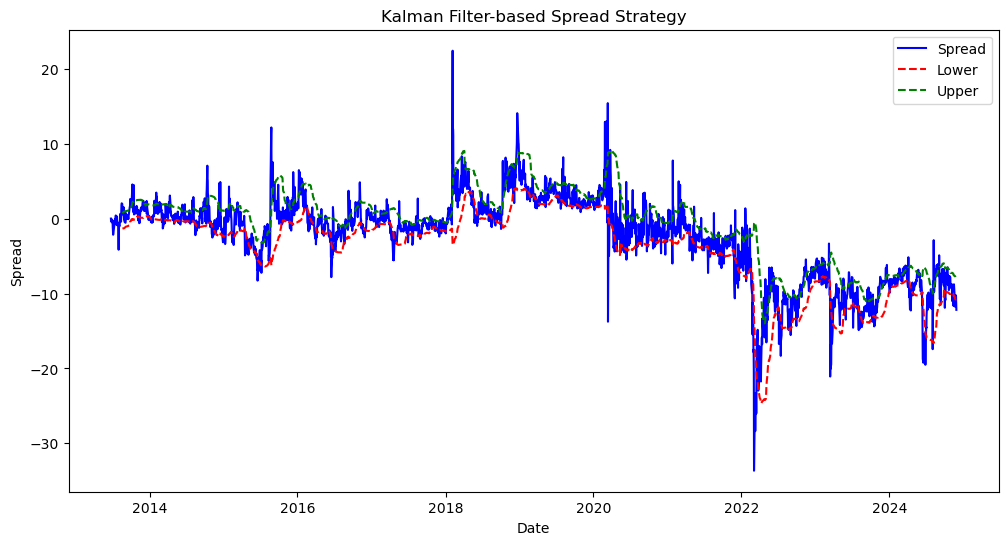

In [70]:
plot_spread(signals_kalman, 'Kalman Filter-based Spread Strategy')

## 8. 최소 총 이익(MTP) 경계를 구하고 이를 이용한 백테스트 결과를 제시하라. (논문과 블로그참조)

In [59]:
def calculate_returns(df,transaction_cost_v1x=0.0002,transaction_cost_v2x=0.0003):

    df = df.copy()

    df['ret_V1X'] = df['V1X_F'].pct_change()
    df['ret_V2X'] = df['V2X_F'].pct_change()
    
    # TODO : transaction cost 계산
    ## V1X : 0.02%, V2X : 0.03%
    ## position_diff : 전일 대비 position의 변화량
    ## transaction_cost, daily_returns, cumulative_returns 계산
    df['position_diff'] = df['position'].diff().abs()
    df['transaction_cost'] = (df['position_diff'] * (transaction_cost_v1x + transaction_cost_v2x) / 2).fillna(0)

    df['daily_returns'] = (
                        0.5 * (df['position'].shift(1) * df['ret_V1X'] - df['position'].shift(1) * df['ret_V2X']) 
                        - df['transaction_cost']
    )
    df['cumulative_returns'] = (1 + df['daily_returns']).cumprod()-1

    return df

In [41]:
def calculate_mtp(df, U, phi, sigma_a, b):

    # AR(1) 과정의 평균 첫 번째 통과 시간을 계산하는 함수
    def mean_first_passage_time(phi, sigma_a, u, b, n=100):
        h = (b - u) / n # 구간 길이
        u_i = np.linspace(u, b, n+1) # 구간
        
        # 커널 행렬 K 계산
        K = np.zeros((n+1, n+1))
        for i in range(n+1):
            for j in range(n+1):
                if i != j:
                    K[i, j] = (h / (2 * np.sqrt(2 * np.pi) * sigma_a)) * np.exp(-((u_i[i] - phi * u_i[j])**2) / (2 * sigma_a**2))

        # 선형 방정식 (I - K)E = 1 풀기
        I = np.eye(n+1)
        E = np.linalg.solve(I - K, np.ones(n+1))
        return E
    
    # 평균 첫 번째 통과 시간 계산
    E = mean_first_passage_time(phi, sigma_a, U, b)

    # TD_U 계산
    TD_U = E[0]

    # I_U 계산
    I_U = mean_first_passage_time(phi, sigma_a, -U, b)[0]

    # MTP 계산
    mtp = (TD_U + I_U - 1) * U
    return mtp

In [42]:
def backtest_strategy(df,method,transaction_cost_v1x=0.0002,transaction_cost_v2x=0.0003):

    df = df.copy()
    df = df.dropna()
    ################ 1. 전략 수익률 계산 ################
    df = calculate_returns(df,transaction_cost_v1x,transaction_cost_v2x)

    ################ 2. MTP 계산 ################
    # ADF 검정을 통해 phi, sigma_a 추정
    adf_result = adfuller(df['spread'].dropna())
    phi = adf_result[0]
    sigma_a = df['spread'].std()

    # 최적의 U 계산
    b = df['spread'].mean()
    U_range = np.arange(0, 5 * sigma_a, 0.01)   # U의 후보군
    mtp_values = [calculate_mtp(df, U, phi, sigma_a, b) for U in U_range] # MTP 계산 Simulation
    optimal_U = U_range[np.argmax(mtp_values)]  # MTP가 최대가 되는 U 선택
    mtp = np.max(mtp_values)  # 최대 MTP

    # # MTP를 고려한 누적 수익률 계산
    # df['cumulative_returns_after_mtp'] = df['cumulative_returns'] - mtp

    ################ 3. 성과 분석 ################
    # 1) CAGR
    num_years = len(df['daily_returns']) / 252
    cagr = (1 + df['cumulative_returns'][-1]) ** (1/num_years) - 1
    # 2) Volatility
    annualized_volatility = df['daily_returns'].std() * np.sqrt(252)
    # 3) IR Ratio
    ir = (df['daily_returns'].mean() * 252) / annualized_volatility
    # 4) MDD
    peak = df['cumulative_returns'].cummax()
    drawdown = (df['cumulative_returns'] - peak) / peak
    drawdown.replace([np.inf, -np.inf], 0, inplace=True)
    mdd = drawdown.min()
    # 5) Hurst Exponent
    hurst_exponent, c, data = hurst.compute_Hc(df['cumulative_returns'].fillna(0))
    
    # 6) Half-life
    def half_life(spread):
        spread_lag = spread.shift(1)
        spread_lag.iloc[0] = spread_lag.iloc[1]

        spread_ret = spread - spread_lag
        spread_ret.iloc[0] = spread_ret.iloc[1]

        spread_lag2 = sm.add_constant(spread_lag)
        model = sm.OLS(spread_ret,spread_lag2)
        res = model.fit()
        halflife = round(-np.log(2) / res.params[1],2)
        if halflife <= 0:
            halflife = 1        
        return halflife
    half_life_ = half_life(df['spread'])

    
    result = {
        'MTP': mtp,
        'CAGR': cagr,
        'Volatility': annualized_volatility,
        'IR': ir,
        'MDD': mdd,
        'Hurst Exponent': hurst_exponent,
        'Half-life': half_life_
    }

    return pd.DataFrame(result, index=[method])


In [79]:
metrics_simple = backtest_strategy(signals_simple, 'simple', transaction_cost_v1x=0.0002,transaction_cost_v2x=0.0003)
metrics_simple

,MTP,CAGR,Volatility,IR,MDD,Hurst Exponent,Half-life
simple,18.00798,0.722229,0.359244,1.676394,-1.860251,0.723355,6.49


<Axes: >

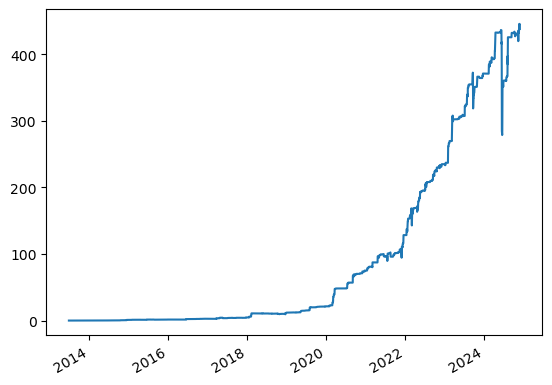

In [80]:
signals_simple_ret = calculate_returns(signals_simple.copy())
(signals_simple_ret['cumulative_returns']).plot()

In [81]:
metrics_smoothed = backtest_strategy(signals_smoothed,'smooth',transaction_cost_v1x=0.0002,transaction_cost_v2x=0.0003)
metrics_smoothed

,MTP,CAGR,Volatility,IR,MDD,Hurst Exponent,Half-life
smooth,18.00798,0.166194,0.105044,1.515438,-3.419683,0.777706,6.49


<Axes: >

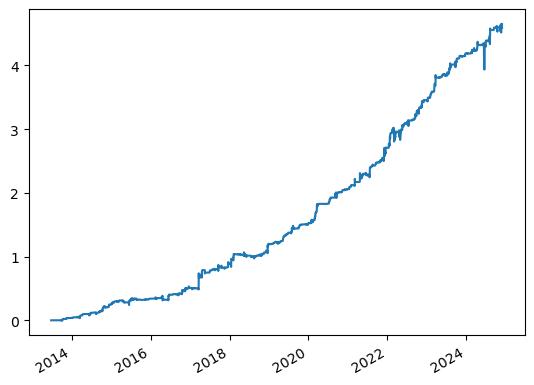

In [82]:
signals_smoothed_ret = calculate_returns(signals_smoothed.copy())
(signals_smoothed_ret['cumulative_returns']).plot()

In [83]:
metrics_coint = backtest_strategy(signals_coint,'coint',transaction_cost_v1x=0.0002,transaction_cost_v2x=0.0003)
metrics_coint

,MTP,CAGR,Volatility,IR,MDD,Hurst Exponent,Half-life
coint,23.134776,-0.155143,0.357356,-0.099242,-3.219144,0.555506,14.79


<Axes: >

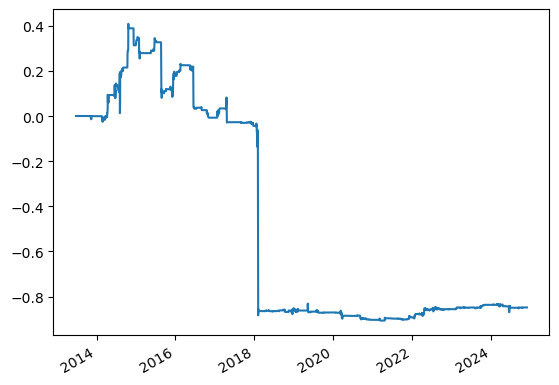

In [100]:
signals_coint_ret = calculate_returns(signals_coint.copy())
(signals_coint_ret['cumulative_returns']).plot()

In [85]:
metrics_kalman = backtest_strategy(signals_kalman, 'karman', transaction_cost_v1x=0.0002,transaction_cost_v2x=0.0003)
metrics_kalman

,MTP,CAGR,Volatility,IR,MDD,Hurst Exponent,Half-life
karman,27.959583,0.677654,0.379491,1.53615,-1.039325,0.714245,13.93


<Axes: >

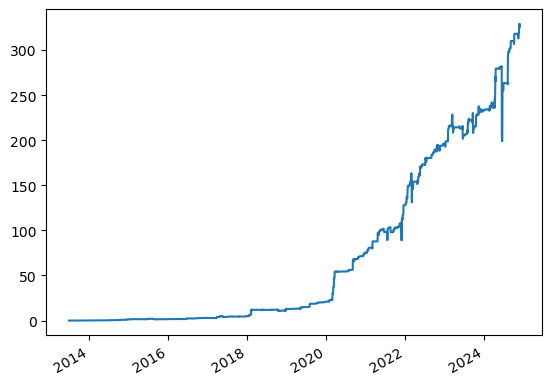

In [86]:
signals_kalman_ret = calculate_returns(signals_kalman.copy())
(signals_kalman_ret['cumulative_returns']).plot()

In [87]:
metrics_df = pd.concat([metrics_simple, metrics_smoothed, metrics_coint, metrics_kalman],axis=0)
metrics_df

,MTP,CAGR,Volatility,IR,MDD,Hurst Exponent,Half-life
simple,18.007980,0.722229,0.359244,1.676394,-1.860251,0.723355,6.49
smooth,18.007980,0.166194,0.105044,1.515438,-3.419683,0.777706,6.49
coint,23.134776,-0.155143,0.357356,-0.099242,-3.219144,0.555506,14.79
karman,27.959583,0.677654,0.379491,1.536150,-1.039325,0.714245,13.93


### (참고) 각 lookback과 k 조합에 대해 전략 계산

In [53]:
# 각 lookback과 k 조합에 대해 전략 계산

# Parameters
lookback_values = [10, 20, 40]
k_values = [0.5, 0.75, 1]

simple_results = {}
performance_metrics = {}
for lookback in lookback_values:
    for k in k_values:
        key = f"lookback={lookback}, k={k}"

        spread_df = simple_spread_strategy(Total_VIX_df, lookback, k)
        spread_df = smooth_positions(spread_df)
        
        simple_results[key] = spread_df

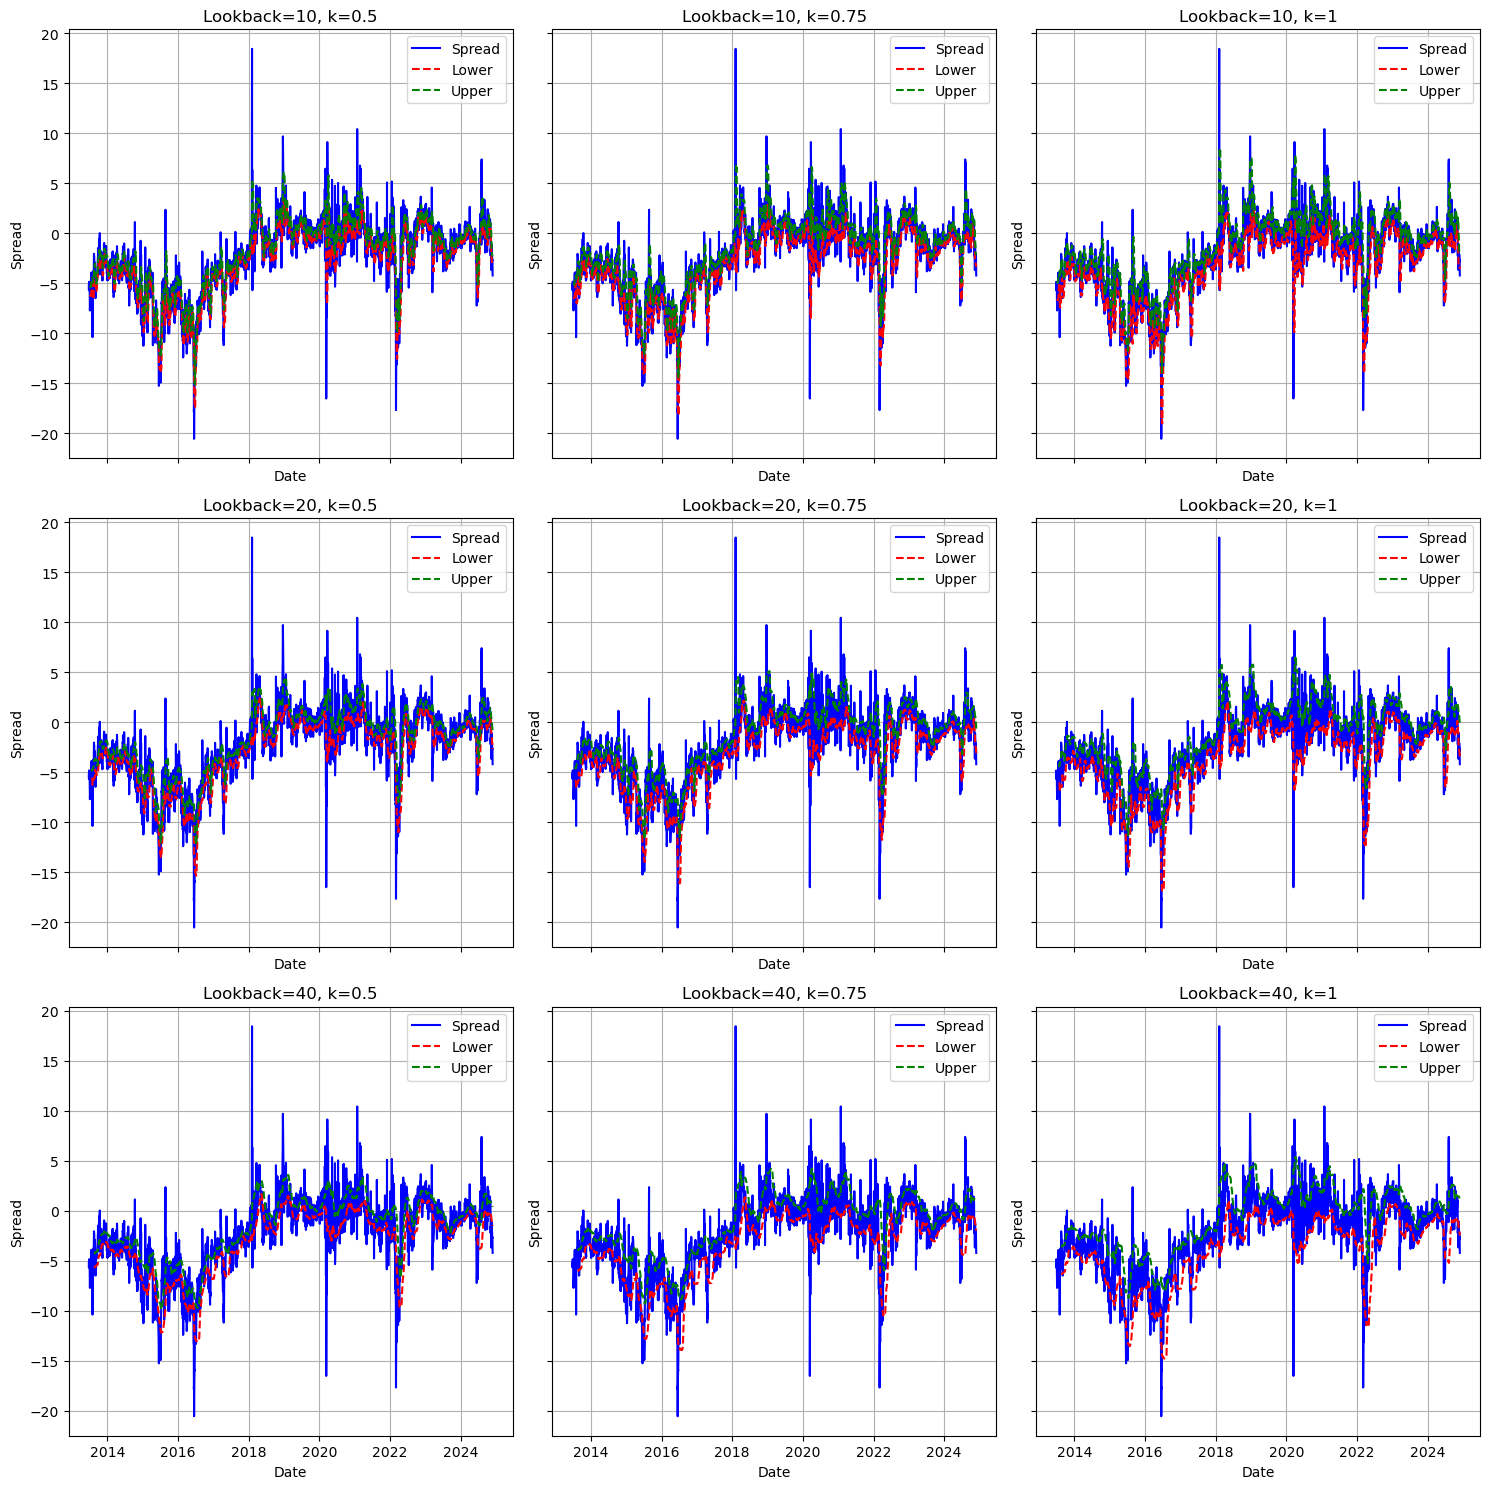

In [54]:
num_lookbacks = len(lookback_values)
num_ks = len(k_values)
fig, axes = plt.subplots(num_lookbacks, num_ks, figsize=(15, 5 * num_lookbacks), sharex=True, sharey=True)

for i, lookback in enumerate(lookback_values):
    for j, k in enumerate(k_values):
        key = f"lookback={lookback}, k={k}"
        result = simple_results[key]

        ax = axes[i, j]

        ax.plot(result.index, result['spread'], label='Spread', color='blue')
        ax.plot(result.index, result['low'], linestyle='--', label='Lower', color='red')
        ax.plot(result.index, result['high'], linestyle='--', label='Upper', color='green')

        ax.set_title(f"Lookback={lookback}, k={k}")
        ax.set_xlabel('Date')
        ax.set_ylabel('Spread')
        ax.grid()
        ax.legend()

plt.tight_layout()
plt.show()